In [ ]:
from zipfile import ZipFile
file_name = "Eyewear_ml_challenge.zip"
with ZipFile(file_name,'r') as zip:
  print('extracting..')
  zip.extractall()
  print('done')

extracting..
done


In [ ]:
!ls

Eyewear_ml_challenge	  model-eyewear.h5  vgg-confusion-rps-1.png
Eyewear_ml_challenge.zip  sample_data


In [ ]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

In [ ]:
train_path="Eyewear_ml_challenge/train"
test_path="Eyewear_ml_challenge/test"
val_path="Eyewear_ml_challenge/val"

In [ ]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt

In [ ]:
x_train=[]

for folder in os.listdir(train_path):
    sub_path=train_path+"/"+folder
    for img in os.listdir(sub_path):
        image_path=sub_path+"/"+img
        img_arr=cv2.imread(image_path)
        img_arr=cv2.resize(img_arr,(224,224))
        x_train.append(img_arr)

In [ ]:
x_test=[]

for folder in os.listdir(test_path):
    sub_path=test_path+"/"+folder
    for img in os.listdir(sub_path):
        image_path=sub_path+"/"+img
        img_arr=cv2.imread(image_path)
        img_arr=cv2.resize(img_arr,(224,224))
        x_test.append(img_arr)

In [ ]:
x_val=[]

for folder in os.listdir(val_path):
    sub_path=val_path+"/"+folder
    for img in os.listdir(sub_path):
        image_path=sub_path+"/"+img
        img_arr=cv2.imread(image_path)
        img_arr=cv2.resize(img_arr,(224,224))
        x_val.append(img_arr)

In [ ]:
train_x=np.array(x_train)
test_x=np.array(x_test)
val_x=np.array(x_val)

In [ ]:
train_x.shape,test_x.shape,val_x.shape

((3340, 224, 224, 3), (1044, 224, 224, 3), (845, 224, 224, 3))

In [ ]:
train_x=train_x/255.0
test_x=test_x/255.0
val_x=val_x/255.0

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'sparse')

test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'sparse')

val_set = val_datagen.flow_from_directory(val_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'sparse')

Found 3340 images belonging to 3 classes.
Found 1044 images belonging to 3 classes.
Found 845 images belonging to 3 classes.


In [ ]:
training_set.class_indices

{'EyeFrame': 0, 'NonPowerReading': 1, 'Sunglasses': 2}

In [ ]:
train_y=training_set.classes

In [ ]:
test_y=test_set.classes

In [ ]:
val_y=val_set.classes

In [ ]:
train_y.shape,test_y.shape,val_y.shape

((3340,), (1044,), (845,))

In [ ]:
# add preprocessing layer to the front of VGG
vgg = VGG19(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [ ]:
# don't train existing weights
for layer in vgg.layers:
    layer.trainable = False

In [ ]:
# our layers - you can add more if you want
x = Flatten()(vgg.output)

prediction = Dense(3, activation='softmax')(x)

In [ ]:
# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

# view the structure of the model
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
# tell the model what cost and optimization method to use
model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer="adam",
  metrics=['accuracy']
)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=5)

#Early stopping to avoid overfitting of model

In [ ]:
# fit the model
history = model.fit(
  train_x,
  train_y,
  validation_data=(val_x,val_y),
  epochs=12,
  callbacks=[early_stop],
  batch_size=32,shuffle=True)

NameError: ignored

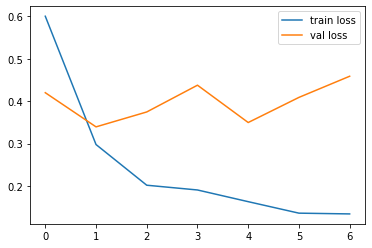

In [ ]:
# loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()

plt.savefig('vgg-loss-rps-1.png')
plt.show()

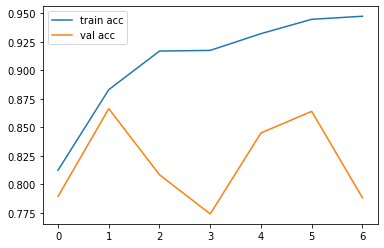

In [ ]:
# accuracies
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()

plt.savefig('vgg-acc-rps-1.png')
plt.show()

In [ ]:
model.evaluate(test_x,test_y,batch_size=5)

209/209 [==============================] - 667s 3s/step - loss: 0.6863 - accuracy: 0.6504


[0.6863496899604797, 0.6503831148147583]

In [ ]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
import numpy as np

In [ ]:
y_pred=model.predict(test_x)
y_pred=np.argmax(y_pred,axis=1)

In [ ]:
accuracy_score(y_pred,test_y)

0.6503831417624522

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

In [ ]:
cm=confusion_matrix(y_pred,test_y)

In [ ]:
cm_df = pd.DataFrame(cm,
                     index = ['EyeFrame', 'NonPowerReading', 'Sunglasses'], 
                     columns = ['EyeFrame', 'NonPowerReading', 'Sunglasses'])

In [ ]:
import seaborn as sns

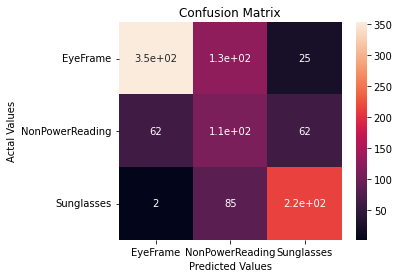

In [ ]:
#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.savefig('vgg-confusion-rps-1.png')
plt.show()

In [ ]:
print(classification_report(y_pred,test_y))

              precision    recall  f1-score   support

           0       0.85      0.70      0.76       507
           1       0.34      0.47      0.40       235
           2       0.71      0.71      0.71       302

    accuracy                           0.65      1044
   macro avg       0.63      0.63      0.62      1044
weighted avg       0.69      0.65      0.67      1044



In [ ]:
model.save('model-eyewear.h5')

In [ ]:
!ls

Eyewear_ml_challenge	  model-eyewear.h5  vgg-confusion-rps-1.png
Eyewear_ml_challenge.zip  sample_data
